In [1]:
from IPython.parallel import Client
#c = Client()
c = Client(profile='parallel_python2.7')
dview = c.direct_view()
lview = c.load_balanced_view()

/usr/local/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
with dview.sync_imports():
    import numpy
    from mitgcmdata import MITgcmmodel, layers, budgets
    from jmd95 import eos
from matplotlib import pyplot as plt
import xray
%matplotlib inline

importing numpy on engine(s)
importing MITgcmmodel,layers,budgets from mitgcmdata on engine(s)
importing eos from jmd95 on engine(s)


In [112]:
%%px --local
dmask = 12
dsuf = '%04d' % -m.zf[dmask]
print dsuf

0243
[stdout:0] 0243
[stdout:1] 0243
[stdout:2] 0243
[stdout:3] 0243
[stdout:4] 0243
[stdout:5] 0243
[stdout:6] 0243
[stdout:7] 0243


In [113]:
%%px --local
ddir = '/data/scratch/rpa/SOSE/run_matt'
#ddir = '/glade/scratch/rpa/SOSE/run_matt_layers'

layers_name = '1RHO'

m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter=480)

extra_mask = numpy.zeros(m.shape)
extra_mask[:,-1] = 1

Slevs = numpy.linspace(32,38,200)

drho1 = 0.002
drho2 = 0.025
rho0 = 1027.9
drho = numpy.hstack([
        drho1 * numpy.ones(100),
        numpy.linspace(drho1, drho2, 200),
        drho2 * numpy.ones(100),
])
rholevs = (rho0 - numpy.cumsum(drho))[::-1]

2160 320  42
[stdout:0] 2160 320  42
[stdout:1] 2160 320  42
[stdout:2] 2160 320  42
[stdout:3] 2160 320  42
[stdout:4] 2160 320  42
[stdout:5] 2160 320  42
[stdout:6] 2160 320  42
[stdout:7] 2160 320  42


In [114]:
N = 438

iter0 = 480
diters= 480
deltaTclock = 900
all_iters = range(iter0, iter0+diters*N, diters)
dview.scatter('iters', all_iters)

<AsyncResult: finished>

In [115]:
%%px
print len(iters)

[stdout:0] 55
[stdout:1] 55
[stdout:2] 55
[stdout:3] 55
[stdout:4] 55
[stdout:5] 55
[stdout:6] 54
[stdout:7] 54


In [116]:
%%px

# mask everything below 670 m depth
extra_mask[dmask+1:] = True

res = []
for i in iters:
    
    theta = m.rdmds('SOstt_5d', i, rec=0)
    salt = m.rdmds('SOstt_5d', i, rec=1)

    #rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
    rho, drhodt, drhods = eos.state_surface(theta.ravel(), salt.ravel())
    rho.shape = theta.shape
    drhods.shape = theta.shape
    drhodt.shape = theta.shape
    
    salt_budget = budgets.TracerBudget(m,
                    'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                    iters=i)
    
    heat_budget = budgets.TracerBudget(m,
                'SO_Tbdg5', 'SO_Surf5d', trname='TH',
                swflux_name='oceQsw',
                swflux_fname='../run_np240/SO_Surf5d',
                iters=i)
    
    wmb_sig0 = budgets.WaterMassBudget(m, rholevs,
                            extra_mask=extra_mask)
    #trs, labels = wmb_salt.calc_transformation_rates(salt, salt_budget)
    wmt_salt, labels_salt = wmb_sig0.calc_transformation_rates(rho, salt_budget, scalefac=drhods)
    wmt_heat, labels_heat = wmb_sig0.calc_transformation_rates(rho, heat_budget, scalefac=drhodt)

    res.append([wmt_salt, wmt_heat])

In [117]:
%%px

print len(res)

[stdout:0] 55
[stdout:1] 55
[stdout:2] 55
[stdout:3] 55
[stdout:4] 55
[stdout:5] 55
[stdout:6] 54
[stdout:7] 54


In [118]:
allres_upper = dview.gather('res')

In [119]:
wmt_upper = allres_upper.get()
wmt_all = numpy.array([numpy.vstack([w[0], w[1]]) for w in wmt_upper])
wmt_salt_upper = numpy.array([w[0] for w in wmt_upper])
wmt_heat_upper = numpy.array([w[1] for w in wmt_upper])
print wmt_all.shape

(438, 15, 399)


In [120]:
labels_salt = dview['labels_salt'][0]
labels_heat = dview['labels_heat'][0]
labels_all = ['salt_' + l for l in labels_salt] + ['heat_' + l for l in labels_heat]

time = (numpy.datetime64('2005-01-01 00:00:00') + 
        numpy.array([numpy.timedelta64(deltaTclock) * i for i in all_iters]))
sigma0 = rholevs[1:]-1000.
ds = xray.Dataset(coords={'sigma0': sigma0, 'time': time}, attrs={'depth_range': 'upper %g meters' % -m.zf[dmask]})

for n in range(len(labels_all)):
    ds[labels_all[n]] = xray.DataArray(wmt_all[:,n],
                        coords=[time, sigma0], dims=('time', 'sigma0'))

ds.to_netcdf('../data/wmt_upper_%sm.nc' % dsuf)

-c:6: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [25]:
final_iters = dview.gather('iters')

In [26]:
wmt = allres.get()
wmt_salt = numpy.array([w[0] for w in wmt])
wmt_heat = numpy.array([w[1] for w in wmt])

NameError: name 'allres' is not defined

In [105]:
# save data
numpy.savez('../data/wmt_full_depth', wmt_salt=wmt_salt, wmt_heat=wmt_heat)
numpy.savez('../data/wmt_upper_%sm' % dsuf, wmt_salt=wmt_salt_upper, wmt_heat=wmt_heat_upper)


In [7]:
numpy.save('../data/rholevs', rholevs)


In [38]:
labels_salt = dview['labels_salt'][0]
labels_heat = dview['labels_heat'][0]
T = numpy.arange(len(all_iters))
rlev = rholevs[1:]-1000.

print labels_salt
print labels_heat

['surfflux', 'linfs', 'adv', 'hdiff', 'kpp', 'tot', 'vdiff']
['surfflux', 'linfs', 'adv', 'kpp', 'vdiff', 'sw', 'tot', 'hdiff']


In [91]:
wmtu = numpy.vstack([wmt_salt_upper.mean(axis=0),  wmt_heat_upper.mean(axis=0)])/1e6
print wmtu.shape
labels = ['salt_'+l for l in labels_salt] + ['heat_'+l for l in labels_heat]
print labels

(15, 399)
['salt_surfflux', 'salt_linfs', 'salt_adv', 'salt_hdiff', 'salt_kpp', 'salt_tot', 'salt_vdiff', 'heat_surfflux', 'heat_linfs', 'heat_adv', 'heat_kpp', 'heat_vdiff', 'heat_sw', 'heat_tot', 'heat_hdiff']


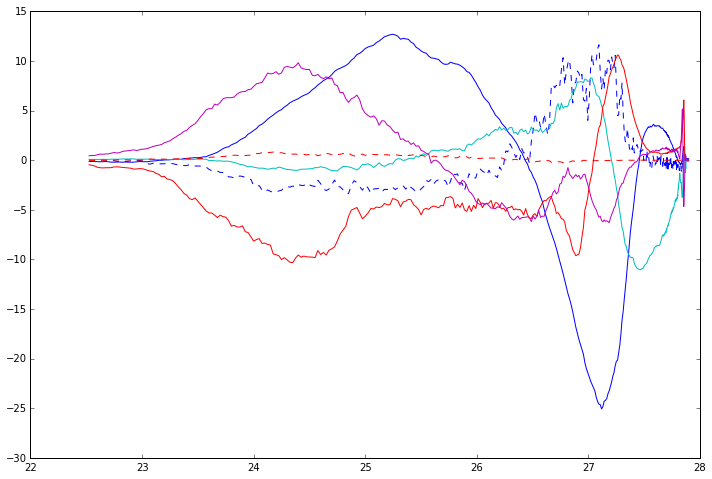

In [109]:
plt.figure(figsize=(12,8)) 
plt.plot(rlev, wmt[0], 'b',         # salt_surfflux
         rlev, wmt[1], 'b--',         # salt_linfs
         rlev, wmt[4]+wmt[6], 'c',         # salt_kpp + salt_vdiff
         rlev, wmt[7]+wmt[12], 'r', # heat_surfflux + heat_swflux
         rlev, wmt[8], 'r--' ,      # heat_linfs
         rlev, wmt[11], 'm',         # heat_kpp + heat_vdiff
        )
#plt.legend(labels_salt + labels_heat, loc='lower left')

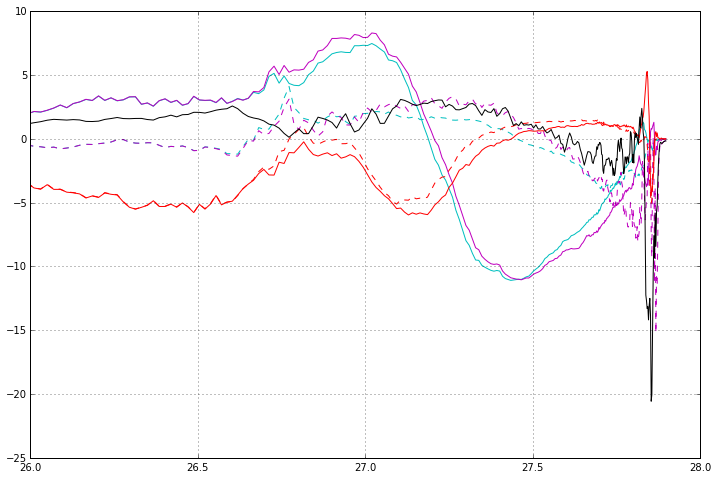

In [112]:
plt.figure(figsize=(12,8)) 
plt.plot(#rlev, wmtu[0], 'b',         # salt_surfflux
         #rlev, wmtu[1], 'b--',         # salt_linfs
         rlev, wmtu[4]+wmtu[6], 'c',         # salt_kpp + salt_vdiff
         rlev, wmtu[3], 'c--',         # salt_kpp + salt_vdiff
         rlev, wmt[4]+wmt[6], 'm',         # salt_kpp + salt_vdiff
         rlev, wmt[3], 'm--',         # salt_kpp + salt_vdiff
         #rlev, wmtu[7]+wmtu[12], 'r', # heat_surfflux + heat_swflux
         #rlev, wmtu[8], 'r--' ,      # heat_linfs
         rlev, wmtu[10]+wmtu[11], 'r--',         # heat_kpp + heat_vdiff
         rlev, wmt[10]+wmt[11], 'r-',         # heat_kpp + heat_vdiff
         rlev, wmt[-1]+wmt[3], 'k'
        )
plt.xlim([26,28])
plt.grid()
#plt.legend(labels_salt + labels_heat, loc='lower left')

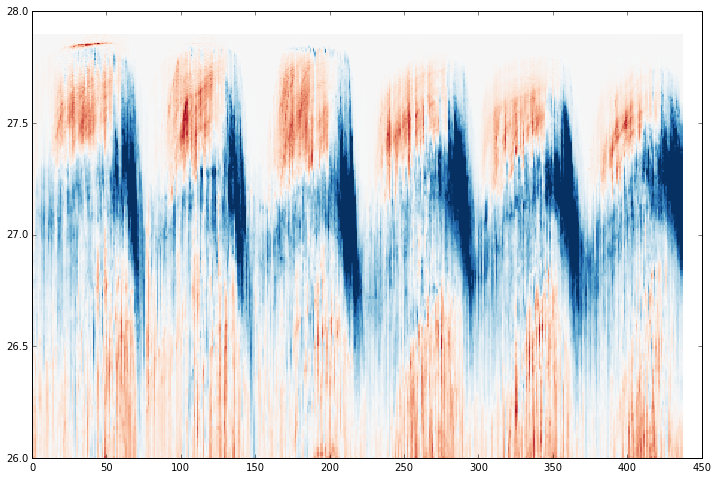

In [31]:
plt.figure(figsize=(12,8))

plt.pcolormesh(T, , wmt_salt[:,0].T/1e6, cmap='RdBu_r')
plt.ylim([26,28])
plt.clim([-50,50])

In [ ]:
labels = dview

In [ ]:
labels = dview[0].pull

In [ ]:
labels = dview[0].get

In [76]:
m.rc[16,0,0]

-438.5